# Spearman correlation
AIDS: Dados provenientes de http://www2.aids.gov.br/cgi/deftohtm.exe?tabnet/sp.def

TUBERCULOSE: Dados provenientes de http://tabnet.datasus.gov.br (cabeçalhos adaptados)

ONCOLOGIA: http://tabnet.datasus.gov.br/cgi/webtabx.exe?PAINEL_ONCO/PAINEL_ONCOLOGIABR.def

VIOLENCIA: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sinannet/cnv/violebr.def

POPULACAO ESTIMADA DOS MUNICIPIOS: https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html => Perfil_Municipios => 2017 => Baixar Base_MUNIC_2017_xls.zip => Em Base MUNIC 2017.xls ir na aba Variaveis Externas

Import libraries

In [1]:
import pandas as pd
import glob
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
pd.set_option('display.max_columns', 200)

Read suicide csv

In [2]:
suicide = pd.read_csv('../Suicide/suicide_count_res.csv', sep=',')
suicide.head()

,CODMUNRES,SUICIDES
0,110001,3
1,110002,10
2,110004,5
3,110005,1
4,110006,2


Let's calculate the suicide rates

In [3]:
populacao_municipios = pd.read_excel('../util/POPMUN.xls', sheet_name='Variáveis externas')
populacao_municipios.head()

,CodMun,REGIAO,COD UF,UF,NOME MUNIC,POP EST,CLASSE POP
0,1100015,1 - Norte,11,RO,Alta Floresta DOeste,25437,4 - 20001 até 50000
1,1100023,1 - Norte,11,RO,Ariquemes,107345,6 - 100001 até 500000
2,1100031,1 - Norte,11,RO,Cabixi,6224,2 - 5001 até 10000
3,1100049,1 - Norte,11,RO,Cacoal,88507,5 - 50001 até 100000
4,1100056,1 - Norte,11,RO,Cerejeiras,17934,3 - 10001 até 20000


In [4]:
populacao_municipios = populacao_municipios[['CodMun', 'POP EST']]
populacao_municipios.columns = ['CODMUN', 'POPULACAO']

In [5]:
# Tira o ultimo digito do CODMUN
populacao_municipios['CODMUN'] = populacao_municipios['CODMUN'].astype(str).str.slice(stop=6).astype(np.int64)
populacao_municipios.head()

,CODMUN,POPULACAO
0,110001,25437
1,110002,107345
2,110003,6224
3,110004,88507
4,110005,17934


In [6]:
suicide = pd.merge(suicide, populacao_municipios, left_on="CODMUNRES", right_on="CODMUN", how="left")
suicide

,CODMUNRES,SUICIDES,CODMUN,POPULACAO
0,110001,3,110001.0,25437.0
1,110002,10,110002.0,107345.0
2,110004,5,110004.0,88507.0
3,110005,1,110005.0,17934.0
4,110006,2,110006.0,18467.0
...,...,...,...,...
3144,522160,4,522160.0,40082.0
3145,522170,1,522170.0,14195.0
3146,522185,6,522185.0,159500.0
3147,522200,1,522200.0,13675.0


In [7]:
suicide[suicide['POPULACAO'].isnull()].shape

(10, 4)

In [8]:
suicide = suicide.dropna()

Let's use the suicide rate, instead of the quantity of suicides

In [9]:
suicide['SUICIDES'] = suicide['SUICIDES'] * 100000 / suicide['POPULACAO']
suicide.head()

,CODMUNRES,SUICIDES,CODMUN,POPULACAO
0,110001,11.793844,110001.0,25437.0
1,110002,9.315758,110002.0,107345.0
2,110004,5.649271,110004.0,88507.0
3,110005,5.576001,110005.0,17934.0
4,110006,10.830129,110006.0,18467.0


In [10]:
suicide['SUICIDES'].describe()

count    3139.000000
mean       14.436963
std        13.689095
min         1.138304
25%         5.668131
50%         9.956193
75%        18.263174
max       153.139357
Name: SUICIDES, dtype: float64

Read disease files

In [11]:
year = "2017"
disease = ""
all_files = glob.glob("CSV/Rates/*.csv")

diseases_list = []
corrs_list = []
p_value_list = []
sizes_list = []
path = 'CSV/Rates/'
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("BR")[0]
    disease_df = pd.read_csv(path + disease + 'BR' + year + '_RATE.csv', sep=',')
    disease_df = disease_df[["QUANTIDADE_RATE", "MUNCOD"]]
    
    # Merge Files
    result_df = pd.merge(disease_df, suicide, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
    result_df = result_df[["QUANTIDADE_RATE", "SUICIDE_RATE"]]
    
    # Spearman correlation
    file_array = result_df.iloc[:,0].values
    suicides_array = result_df.iloc[:,1].values
    corr, p_value = spearmanr(file_array,suicides_array)
    
    # Append correlation
    sizes_list.append(result_df.shape[0])
    diseases_list.append(disease)
    corrs_list.append(corr)
    p_value_list.append(p_value)

['CSV/Rates\\AIDSBR2017_RATE.csv']
['CSV/Rates\\CANCERBR2017_RATE.csv']
['CSV/Rates\\DENGUEBR2017_RATE.csv']
['CSV/Rates\\MENTALBR2017_RATE.csv']
['CSV/Rates\\TUBERCULOSEBR2017_RATE.csv']
['CSV/Rates\\VIOLENCIABR2017_RATE.csv']


Spearman correlations table

In [12]:
corrs_data = {'Doenças': diseases_list, 'Correlação com suicidio': corrs_list, 'P value': p_value_list, 'Número de municípios': sizes_list}
corrs_df = pd.DataFrame(data=corrs_data)
corrs_df

,Doenças,Correlação com suicidio,P value,Número de municípios
0,AIDS,-0.405111,1.318593e-83,2096
1,CANCER,-0.484583,1.280410e-180,3071
2,DENGUE,-0.310800,1.538957e-51,2248
3,MENTAL,-0.283389,1.333362e-54,2895
4,TUBERCULOSE,-0.494473,1.307341e-159,2587
5,VIOLENCIA,-0.355154,7.834489e-89,2964


Table with diseases and suicide numbers merged per city

In [13]:
all_diseases = suicide[["SUICIDE_RATE", "CODMUNRES"]]
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("BR")[0]
    disease_df = pd.read_csv(path + disease + 'BR' + year + '_RATE.csv', sep=',')
    disease_df = disease_df[["QUANTIDADE_RATE", "MUNCOD"]]
    disease_df.rename(columns={"QUANTIDADE_RATE": disease}, inplace=True)
    
    # Merge with current dataframe
    result = pd.merge(file, result, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
    #result = pd.merge(result, populacao_municipios, left_on="CODMUNRES", right_on="CODMUN", how="left")

# Add SUICIDES to columns
result = result[diseases_list + ["SUICIDES"]] # ["SUICIDES", "POPULACAO"]]
result

,AIDS,CANCER,DENGUE,MENTAL,TUBERCULOSE,VIOLENCIA,SUICIDES,POPULACAO
0,25.0,66,60,92,36,93,9.315758,107345.0
1,9.0,133,24,32,26,33,5.649271,88507.0
2,10.0,28,32,10,18,19,7.915776,25266.0
3,4.0,15,253,5,2,5,5.576001,17934.0
4,2.0,11,2,4,2,4,9.440196,10593.0
...,...,...,...,...,...,...,...,...
1435,7.0,29,159,19,5,48,9.979542,40082.0
1436,2.0,7,45,10,1,7,7.044734,14195.0
1437,19.0,63,416,81,31,229,3.761755,159500.0
1438,1.0,10,36,29,1,3,7.312614,13675.0


Transform diseases' quantities in rates

In [14]:
#for disease in diseases_list:
#    result[disease] = result[disease] * 100000 / result["POPULACAO"]
result.head()

,AIDS,CANCER,DENGUE,MENTAL,TUBERCULOSE,VIOLENCIA,SUICIDES,POPULACAO
0,25.0,66,60,92,36,93,9.315758,107345.0
1,9.0,133,24,32,26,33,5.649271,88507.0
2,10.0,28,32,10,18,19,7.915776,25266.0
3,4.0,15,253,5,2,5,5.576001,17934.0
4,2.0,11,2,4,2,4,9.440196,10593.0


Heatmap of the diseases and suicide

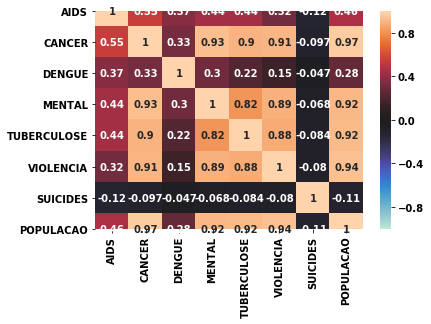

In [15]:
sns.heatmap(all_diseases.corr(), annot=True, vmin=-1, vmax=1, center=0)

## Scatter Plot
Scatter plot to visualize relationship between suicide and hospital adminissions for mental conditions

Load file

In [78]:
disease_df = pd.read_csv('CSV/Quantity/MENTALBR2017.csv', sep=',')
suicide_df = pd.read_csv('../Suicide/CSV/suicides_codmunres.csv')

Merge files

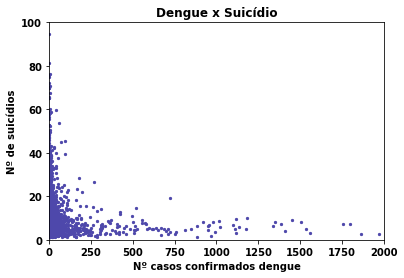

In [16]:
result = pd.merge(disease_df, suicide_df, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
result = result[["QUANTIDADE", "SUICIDES"]]

Plot

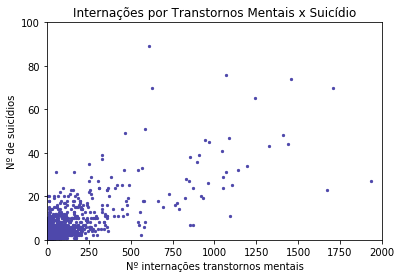

In [83]:
plt.scatter(result["QUANTIDADE"], result["SUICIDES"], s=5, color='#4e48ab')
plt.xlabel("Nº internações transtornos mentais")
plt.ylabel("Nº de suicídios")
plt.title("Internações por Transtornos Mentais x Suicídio")
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([0,100])
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#f8fafb'
plt.rcParams['savefig.facecolor'] = '#33364f'


## Correlation between Morbidity by Residence Location and Suicide

Read morbidity file

In [17]:
df_morb_hosp_res_2017 = pd.read_csv('./morbidity/MORB_HOSP_RES_BR_2017.csv', sep=';', skiprows=3, skipfooter=6)

In [18]:
df_morb_hosp_res_2017.head()

,Município,Cap 01,Cap 02,Cap 03,Cap 04,Cap 05,Cap 06,Cap 07,Cap 08,Cap 09,Cap 10,Cap 11,Cap 12,Cap 13,Cap 14,Cap 15,Cap 16,Cap 17,Cap 18,Cap 19,Cap 21,Total
0,110001 Alta Floresta D'Oeste,391,87,32,50,3,21,11,6,220,518,216,18,39,410,352,9,10,28,283,25,2729
1,110037 Alto Alegre dos Parecis,240,51,15,14,1,11,1,2,57,230,90,26,3,101,120,4,4,10,65,18,1063
2,110040 Alto Paraíso,143,34,20,33,5,5,9,1,37,167,39,23,6,110,121,20,5,20,115,22,935
3,110034 Alvorada D'Oeste,108,51,15,32,4,10,3,2,96,163,64,21,5,109,153,8,3,11,86,71,1015
4,110002 Ariquemes,607,259,108,199,92,74,95,10,597,1003,462,159,104,500,1307,112,33,199,884,141,6945


In [19]:
df_morb_hosp_res_2017 = df_morb_hosp_res_2017.rename(columns={"Município": "MUNICIPIO"})
df_morb_hosp_res_2017['MUNCOD'] = df_morb_hosp_res_2017['MUNICIPIO'].str.extract('(\\d+)').dropna().astype(np.int64)
df_morb_hosp_res_2017['MUNNOME'] = df_morb_hosp_res_2017['MUNICIPIO'].str.extract('([a-zA-Z ]+)')
df_morb_hosp_res_2017['MUNNOME'] = df_morb_hosp_res_2017['MUNNOME'].str.strip()
df_morb_hosp_res_2017 = df_morb_hosp_res_2017.drop('MUNICIPIO', axis=1)
df_morb_hosp_res_2017.head()

,Cap 01,Cap 02,Cap 03,Cap 04,Cap 05,Cap 06,Cap 07,Cap 08,Cap 09,Cap 10,Cap 11,Cap 12,Cap 13,Cap 14,Cap 15,Cap 16,Cap 17,Cap 18,Cap 19,Cap 21,Total,MUNCOD,MUNNOME
0,391,87,32,50,3,21,11,6,220,518,216,18,39,410,352,9,10,28,283,25,2729,110001.0,Alta Floresta D
1,240,51,15,14,1,11,1,2,57,230,90,26,3,101,120,4,4,10,65,18,1063,110037.0,Alto Alegre dos Parecis
2,143,34,20,33,5,5,9,1,37,167,39,23,6,110,121,20,5,20,115,22,935,110040.0,Alto Para
3,108,51,15,32,4,10,3,2,96,163,64,21,5,109,153,8,3,11,86,71,1015,110034.0,Alvorada D
4,607,259,108,199,92,74,95,10,597,1003,462,159,104,500,1307,112,33,199,884,141,6945,110002.0,Ariquemes


In [20]:
df_morb_hosp_res_2017 = pd.merge(df_morb_hosp_res_2017, suicide, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
df_morb_hosp_res_2017.head()

,Cap 01,Cap 02,Cap 03,Cap 04,Cap 05,Cap 06,Cap 07,Cap 08,Cap 09,Cap 10,Cap 11,Cap 12,Cap 13,Cap 14,Cap 15,Cap 16,Cap 17,Cap 18,Cap 19,Cap 21,Total,MUNCOD,MUNNOME,CODMUNRES,SUICIDES,CODMUN,POPULACAO
0,391,87,32,50,3,21,11,6,220,518,216,18,39,410,352,9,10,28,283,25,2729,110001.0,Alta Floresta D,110001,11.793844,110001.0,25437.0
1,240,51,15,14,1,11,1,2,57,230,90,26,3,101,120,4,4,10,65,18,1063,110037.0,Alto Alegre dos Parecis,110037,7.119972,110037.0,14045.0
2,143,34,20,33,5,5,9,1,37,167,39,23,6,110,121,20,5,20,115,22,935,110040.0,Alto Para,110040,4.781029,110040.0,20916.0
3,607,259,108,199,92,74,95,10,597,1003,462,159,104,500,1307,112,33,199,884,141,6945,110002.0,Ariquemes,110002,9.315758,110002.0,107345.0
4,79,58,12,51,3,13,19,-,89,134,94,58,19,119,138,17,10,16,242,39,1210,110045.0,Buritis,110045,2.561213,110045.0,39044.0


In [21]:
df_morb_hosp_res_2017 = df_morb_hosp_res_2017.replace('-', '0')
df_morb_hosp_res_2017.head()

,Cap 01,Cap 02,Cap 03,Cap 04,Cap 05,Cap 06,Cap 07,Cap 08,Cap 09,Cap 10,Cap 11,Cap 12,Cap 13,Cap 14,Cap 15,Cap 16,Cap 17,Cap 18,Cap 19,Cap 21,Total,MUNCOD,MUNNOME,CODMUNRES,SUICIDES,CODMUN,POPULACAO
0,391,87,32,50,3,21,11,6,220,518,216,18,39,410,352,9,10,28,283,25,2729,110001.0,Alta Floresta D,110001,11.793844,110001.0,25437.0
1,240,51,15,14,1,11,1,2,57,230,90,26,3,101,120,4,4,10,65,18,1063,110037.0,Alto Alegre dos Parecis,110037,7.119972,110037.0,14045.0
2,143,34,20,33,5,5,9,1,37,167,39,23,6,110,121,20,5,20,115,22,935,110040.0,Alto Para,110040,4.781029,110040.0,20916.0
3,607,259,108,199,92,74,95,10,597,1003,462,159,104,500,1307,112,33,199,884,141,6945,110002.0,Ariquemes,110002,9.315758,110002.0,107345.0
4,79,58,12,51,3,13,19,0,89,134,94,58,19,119,138,17,10,16,242,39,1210,110045.0,Buritis,110045,2.561213,110045.0,39044.0


In [22]:
for chapter in range(1, 22):
    if chapter == 20:
        continue
    else:
        chapter_str = 'Cap {:02d}'.format(chapter)
        df_morb_hosp_res_2017[chapter_str] = df_morb_hosp_res_2017[chapter_str].astype(np.int64) * 100000 / df_morb_hosp_res_2017['POPULACAO'].astype(np.int64)

df_morb_hosp_res_2017.head()

,Cap 01,Cap 02,Cap 03,Cap 04,Cap 05,Cap 06,Cap 07,Cap 08,Cap 09,Cap 10,Cap 11,Cap 12,Cap 13,Cap 14,Cap 15,Cap 16,Cap 17,Cap 18,Cap 19,Cap 21,Total,MUNCOD,MUNNOME,CODMUNRES,SUICIDES,CODMUN,POPULACAO
0,1537.130951,342.021465,125.800999,196.564060,11.793844,82.556905,43.244093,23.587687,864.881865,2036.403664,849.156740,70.763062,153.319967,1611.825294,1383.810984,35.381531,39.312812,110.075874,1112.552581,98.282030,2729,110001.0,Alta Floresta D,110001,11.793844,110001.0,25437.0
1,1708.793165,363.118548,106.799573,99.679601,7.119972,78.319687,7.119972,14.239943,405.838377,1637.593450,640.797437,185.119260,21.359915,719.117124,854.396582,28.479886,28.479886,71.199715,462.798149,128.159487,1063,110037.0,Alto Alegre dos Parecis,110037,7.119972,110037.0,14045.0
2,683.687129,162.554982,95.620578,157.773953,23.905144,23.905144,43.029260,4.781029,176.898068,798.431823,186.460126,109.963664,28.686173,525.913177,578.504494,95.620578,23.905144,95.620578,549.818321,105.182635,935,110040.0,Alto Para,110040,4.781029,110040.0,20916.0
3,565.466487,241.278122,100.610182,185.383576,85.704970,68.936606,88.499697,9.315758,556.150729,934.370488,430.388001,148.120546,96.883879,465.787880,1217.569519,104.336485,30.742000,185.383576,823.512972,131.352182,6945,110002.0,Ariquemes,110002,9.315758,110002.0,107345.0
4,202.335826,148.550353,30.734556,130.621863,7.683639,33.295769,48.663047,0.000000,227.947956,343.202541,240.754021,148.550353,48.663047,304.784346,353.447393,43.540621,25.612130,40.979408,619.813544,99.887307,1210,110045.0,Buritis,110045,2.561213,110045.0,39044.0


In [23]:
chapter_list = []
spearman_corrs_list = []
p_value_list = []
pearson_corrs_list = []

for chapter in range(1, 22):
    if chapter == 20:
        continue
    else:
        chapter_str = 'Cap {:02d}'.format(chapter)
        result = df_morb_hosp_res_2017[[chapter_str, 'SUICIDES']]
        
        # Correlations
        chapter_array = result.iloc[:,0].values
        suicides_array = result.iloc[:,1].values
        spearman_corr, p_value = spearmanr(chapter_array, suicides_array)
        pearson_corr = result['SUICIDES'].astype(np.int64).corr(result[chapter_str].astype(np.int64))
        
        # Append correlation
        chapter_list.append(chapter_str)
        spearman_corrs_list.append(spearman_corr)
        p_value_list.append(p_value)
        pearson_corrs_list.append(pearson_corr)

In [24]:
corrs_data = {'Capítulos': chapter_list, 'Correlação Spearman': spearman_corrs_list, 'Correlação Pearson': pearson_corrs_list, 'P value': p_value_list}
corrs_df = pd.DataFrame(data=corrs_data)
corrs_df

,Capítulos,Correlação Spearman,Correlação Pearson,P value
0,Cap 01,0.011282,0.024734,5.274734e-01
1,Cap 02,0.206444,0.280593,1.469815e-31
2,Cap 03,0.029285,0.087710,1.009122e-01
3,Cap 04,0.058867,0.028138,9.678714e-04
4,Cap 05,0.191308,0.233627,2.950164e-27
5,Cap 06,0.100117,0.163422,1.897045e-08
6,Cap 07,-0.128962,-0.057509,4.083307e-13
7,Cap 08,-0.141547,0.102895,1.620480e-15
8,Cap 09,0.219578,0.202521,1.405454e-35
9,Cap 10,0.181973,0.153637,8.927686e-25
